In [1]:
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base


#import modules for news selection
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim import models




# section 2

In [3]:
data = pd.read_csv('Recent_Contract_Awards.csv',low_memory=False)


In [4]:
#question 1

import datetime


data.loc[:, 'StartDate'] = pd.to_datetime(data['StartDate'])
data_2010_2019 = data[data['StartDate']>=datetime.datetime(2010, 1, 1)]
data_2010_2019 =data_2010_2019[data_2010_2019['StartDate']<=datetime.datetime(2019,12,31)]
data_filtered = data_2010_2019.copy()
data_filtered = data_filtered[data_filtered['ContractAmount']>0]
data_filtered = data_filtered.dropna(subset=['ContractAmount'])
data_filtered['ContractAmount'].sum()

207783994327.83997

In [5]:
#question 2

data_vendor = data_filtered.copy()
data_vendor_agency= data_vendor[data_vendor['AgencyName']=='Citywide Administrative Services']
data_vendor_sum = data_vendor_agency.groupby('VendorName')['ContractAmount'].sum()
data_vendor_sum_df = pd.DataFrame(data_vendor_sum).reset_index()
test= data_vendor_sum_df.copy()
test['count'] = list( data_vendor_agency.groupby('VendorName')['RequestID'].count())
total = test['count'].sum()
test_50 = test.sort_values(by=['ContractAmount'], ascending = False).head(50)
total_50 = test_50['count'].sum()
total_50/total

0.038642604943114944

In [6]:
# question 3
data_construction = data_filtered.copy()
data_construction['construction'] = data_construction['CategoryDescription'].apply(lambda s: s == 'Construction/Construction Services' or s=='Construction Related Services')

data_construction = data_construction[data_construction['construction'] == True]


central_park = data_construction.copy()
central_park['CentralPark'] = central_park['ShortTitle'].apply(lambda s:('park' in s.lower().split(' ')) and ('central park' in s.lower()))
count_central_park = len(central_park[central_park['CentralPark']==True])

washington = data_construction.copy()
#washington['Washington'] = washington['ShortTitle'].apply(lambda s:('washington' in s.lower().split(' ')) and ('square' in s.lower().split(' ')) and ('park' in s.lower().split(' ')) and 'washington square park' in s.lower() )
washington['Washington'] = washington['ShortTitle'].apply(lambda s:('WASHINGTON SQUARE PARK' in s))
count_washington = len(washington[washington['Washington']==True])

count_central_park/count_washington

2.0

In [7]:
# question 4

data_regression = data_vendor_agency.copy()
data_regression['year'] = data_regression['StartDate'].dt.year
data_regression_grp = data_regression.groupby('year')['ContractAmount'].sum()
data_regression_grp = pd.DataFrame(data_regression_grp).reset_index()



from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


# Split the data into training/testing sets
X = pd.DataFrame(data_regression_grp['ContractAmount'])
X = X.to_numpy()
y = data_regression_grp['year']
y = y.to_numpy()
X_train = X[:-1]
X_test = X[-1:]

# Split the targets into training/testing sets
y_train = y[:-1]
y_test = y[-1:]


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [6.38393824e-10]


In [8]:
# question 5

data_contract = data_filtered.copy()
data_contract_grp = data_contract.groupby('AgencyName')['RequestID'].count()
data_contract_df = pd.DataFrame(data_contract_grp).reset_index()
data_contract_df = data_contract_df.rename(columns={'RequestID':'ContractCount'})
data_contract_df['ContractAmountTotal'] = list(data_contract.groupby('AgencyName')['ContractAmount'].sum())
data_contract_df = data_contract_df.sort_values(by=['ContractCount'], ascending=False)
data_contract_df_5 = data_contract_df.head(5).copy(deep=True)
data_contract_df_5['AmountPerContract'] = data_contract_df_5['ContractAmountTotal']/data_contract_df_5['ContractCount']
data_contract_df_5[0:1]['AmountPerContract'].values[0]/data_contract_df_5[1:2]['AmountPerContract'].values[0]

0.07356237122612462

In [9]:
# question 6 chi square
data_agency = data_filtered.copy()
data_agency = data_agency[data_agency['AgencyName']=='Parks and Recreation']
data_agency['year'] = data_agency['StartDate'].dt.year
data_agency['month'] = data_agency['StartDate'].dt.month
data_agency['week'] = data_agency['StartDate'].dt.week
data_agency['weekday'] = data_agency['StartDate'].dt.weekday
data_agency_notice_count = data_agency.groupby('weekday')['RequestID'].count().reset_index()
data_agency_notice_count = data_agency_notice_count.rename(columns={'RequestID':'NoticeCount'})
data_agency_notice_count = data_agency_notice_count.reset_index()

from scipy.stats import chisquare

obs= np.array([data_agency_notice_count['NoticeCount']]).T
chisquare(obs)

Power_divergenceResult(statistic=array([8.62341326]), pvalue=array([0.0712334]))

In [10]:
# question 7 common patterns
data_spending_patterns = data_filtered.copy()

data_spending_patterns['year'] = data_spending_patterns['StartDate'].dt.year
data_spending_patterns['month'] = data_spending_patterns['StartDate'].dt.month
data_spending_patterns_envprotection = data_spending_patterns[data_spending_patterns['AgencyName']=='Environmental Protection']

data_spending_patterns_envprotection_spending = data_spending_patterns_envprotection.groupby(['year','month'])['ContractAmount'].sum()
data_spending_patterns_envprotection_spending_df = pd.DataFrame(data_spending_patterns_envprotection_spending).reset_index()
data_spending_patterns_envprotection_spending_monthly = data_spending_patterns_envprotection_spending_df.groupby('month')['ContractAmount'].sum()
data_spending_patterns_envprotection_spending_monthly_df = pd.DataFrame(data_spending_patterns_envprotection_spending_monthly).reset_index()
data_spending_patterns_envprotection_spending_monthly_df.sort_values(by=['ContractAmount'])


spending_2015_2019 = data_spending_patterns_envprotection_spending_df[data_spending_patterns_envprotection_spending_df['year']>2014]

ContractAmount_df = pd.DataFrame(spending_2015_2019['ContractAmount']/1000000)
ContractAmount_df['year'] = spending_2015_2019['year']
ContractAmount_df['month'] = spending_2015_2019['month']
ContractAmount_df = ContractAmount_df.rename(columns={'members':'ContractAmount'})

In [11]:
data_agency_spending = data_filtered.copy()
data_agency_spending['year'] = data_agency_spending['StartDate'].dt.year
data_agency_spending['month'] = data_agency_spending['StartDate'].dt.month
data_agency_spending['AmountInMillion'] = data_agency_spending['ContractAmount']/1000000

data_agency_spending_group = data_agency_spending.groupby(['AgencyName','month'])['AmountInMillion'].sum()
data_agency_spending_group_df = pd.DataFrame(data_agency_spending_group).reset_index()

data_agency_spending_group_df.head()

,AgencyName,month,AmountInMillion
0,Administration for Children's Services,1,70.697049
1,Administration for Children's Services,2,41.115498
2,Administration for Children's Services,3,127.603679
3,Administration for Children's Services,4,460.568710
4,Administration for Children's Services,5,1435.444439


<AxesSubplot:xlabel='month', ylabel='AmountInMillion'>

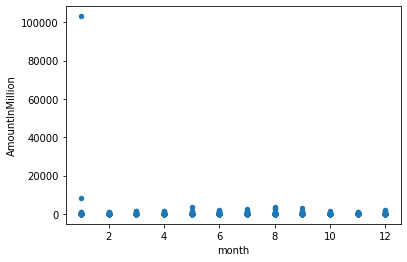

In [12]:
data_agency_spending_group_df.plot.scatter(x='month',y='AmountInMillion')

<AxesSubplot:xlabel='month', ylabel='AmountInMillion'>

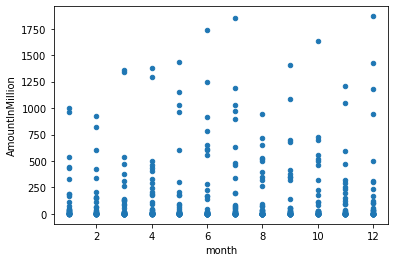

In [13]:
data_agency_spending_less = data_agency_spending_group_df[data_agency_spending_group_df['AmountInMillion']<2000]

data_agency_spending_less['AmountInMillion'].max()
data_agency_spending_less.plot.scatter(x='month',y='AmountInMillion')

In [14]:

from scipy.stats import chisquare

obs= np.array([data_agency_spending_less['AmountInMillion']]).T
chisquare(obs)

Power_divergenceResult(statistic=array([308513.54682823]), pvalue=array([0.]))

In [15]:
data_agency_spending = data_filtered.copy()
data_agency_spending['year'] = data_agency_spending['StartDate'].dt.year
data_agency_spending['month'] = data_agency_spending['StartDate'].dt.month
data_agency_spending['AmountInMillion'] = data_agency_spending['ContractAmount']/1000000

data_agency_count_group = data_agency_spending.groupby(['AgencyName','month'])['RequestID'].count()
data_agency_count_group_df = pd.DataFrame(data_agency_count_group).reset_index()
data_agency_count_group_df = data_agency_count_group_df.rename(columns={'RequestID':'ContractCount'})
data_agency_count_group_df.head()

,AgencyName,month,ContractCount
0,Administration for Children's Services,1,45
1,Administration for Children's Services,2,22
2,Administration for Children's Services,3,42
3,Administration for Children's Services,4,29
4,Administration for Children's Services,5,38


<AxesSubplot:xlabel='month', ylabel='ContractCount'>

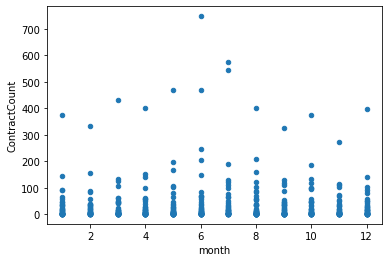

In [16]:
data_agency_count_group_df.plot.scatter(x='month',y='ContractCount')

In [17]:

from scipy.stats import chisquare

obs= np.array([data_agency_count_group_df['ContractCount']]).T
chisquare(obs)

Power_divergenceResult(statistic=array([84142.27398615]), pvalue=array([0.]))

In [18]:
from scipy.stats import entropy
import pandas as pd
def information_gain(members, split):
    
    entropy_before = entropy(members.value_counts(normalize=True))
    split.name = 'split'
    members.name = 'members'
    grouped_distrib = members.groupby(split) \
                        .value_counts(normalize=True) \
                        .reset_index(name='count') \
                        .pivot_table(index='split', columns='members', values='count').fillna(0) 
    entropy_after = entropy(grouped_distrib, axis=1)
    entropy_after *= split.value_counts(sort=False, normalize=True)
    return (entropy_before - entropy_after.sum())/entropy_before

information_gain(ContractAmount_df['ContractAmount'], ContractAmount_df['month'])

0.6148921329288352

# according to informaiton gain between contract amount and month, the two features are related.
# we visualized the contract amount each year, we can see the peak points are between June and September each year.

<AxesSubplot:xlabel='month'>

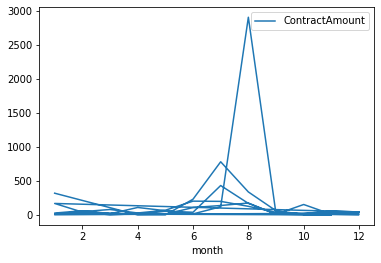

In [19]:
ContractAmount_df.plot.line(x='month', y='ContractAmount')

<AxesSubplot:xlabel='month'>

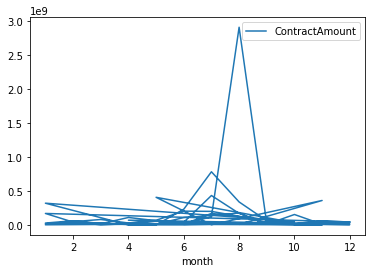

In [20]:
data_spending_patterns_envprotection_spending_df.plot.line(x='month', y='ContractAmount')

In [21]:
# question 8
nyc_zipcodes = pd.read_csv('NYC_ZIPCODE.csv').set_index('zipcode')
data_address = data_filtered.copy()
data_address['year'] = data_address['StartDate'].dt.year
data_address = data_address[data_address['year'] == 2018]
data_address['zipcode'] = data_address['VendorAddress'].apply(lambda s: str(s).split(' ')[-1])
data_address['nyc'] = data_address['zipcode'].apply(lambda s: s in str(nyc_zipcodes.index))
data_address[data_address['nyc']==True]['ContractAmount'].sum()/data_address[data_address['nyc']==False]['ContractAmount'].sum()

0.08462899795171146